In [101]:
import torchvision
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T
import random
import numpy as np


### Pre-trained Model - Mask R-CNN

In [102]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

### Category for COCO Dataset
-  'N/A' is the category that has been removed

In [103]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

### Generate the bounding box for each category

In [218]:
colors = []
number_of_categor = len(COCO_INSTANCE_CATEGORY_NAMES)
for i in range(number_of_categor):
    r = random.randint(20,150)
    g = random.randint(50,200)
    b = random.randint(100,150)
    colors.append((r,g,b)) 

In [219]:
color_dict = dict(zip(COCO_INSTANCE_CATEGORY_NAMES, colors))

### Generate the mask color for each category

In [106]:
def random_colour_masks(image,pred_cls):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
 
    r[image == 1], g[image == 1], b[image == 1] = list(color_dict[pred_cls])
    coloured_mask = np.stack([r, g, b], axis=2)
    
    return coloured_mask

### Given the threshold & get the prediction & mask which prediction's score is greater than threshold.

In [107]:
def get_prediction(img_path, threshold):
    
    img = Image.open(img_path) #Image is obtained from the image path
    transform = T.Compose([T.ToTensor()])#the image is converted to image tensor using PyTorch’s Transforms
    img = transform(img)
    pred = model([img])#mage is passed through the model to get the predictions
    
    # prediction classes and bounding box coordinates are obtained from the model 
    # soft masks are made binary(0 or 1) ie: eg. segment of cat is made 1 and rest of the image is made 0

    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]

    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    
    return masks, pred_boxes, pred_class


### Pipeline for Semantic Segmentation

In [227]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for i in range(len(masks)):
        
  
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=color_dict[pred_cls[i]], thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_DUPLEX, text_size, (255,255,255), thickness=text_th)
              
        rgb_mask = random_colour_masks(masks[i],pred_cls[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.9, 0)
    
    
    
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

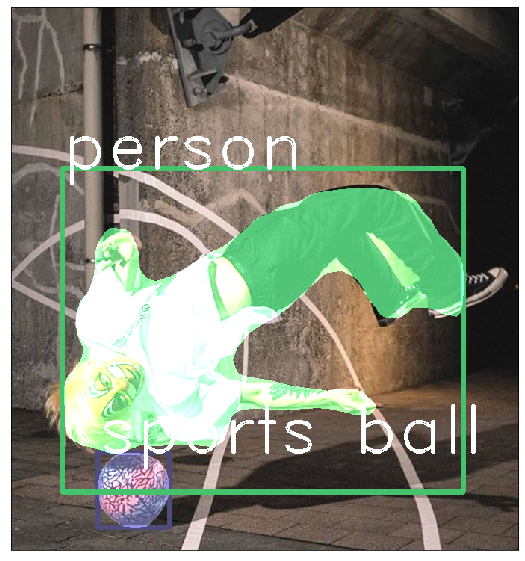

In [228]:
instance_segmentation_api('test.jpg', rect_th=5, text_th=2, text_size=3, threshold=0.8)